# 100 Ohm differential stripline benchmark

The stripline is a commonly used transmission line in printed circuit board (PCB) designs. Compared to the microstrip, the advantage of the stripline includes better shielding from EM interference, lower radiation loss, and better performance at higher frequencies. These strengths make it suitable for use in high-speed interconnects, where bandwidth, package size, and signal integrity are key concerns.

In this notebook, we will build a 100 Ohm edge-coupled differential stripline and simulate it from 1 to 70 GHz. The results will be compared with benchmark data from other commercial RF simulation software. Both 2D mode solver and 3D FDTD results are presented. 

<center><img src="./img/differential_stripline_render.png" width=480 /></center>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.plugins.microwave as mw
import tidy3d.plugins.smatrix as sm
from tidy3d.plugins.dispersion import FastDispersionFitter

td.config.logging_level = "ERROR"

### Building the Simulation

### Key Parameters

We begin by defining some key parameters. The design impedance $Z_0$ for the differential mode will be 100 Ohms. The geometry parameters are chosen with that in mind. Material properties are assumed constant over the frequency band. 

<center><img src="./img/differential_stripline_schematic.png" width=400 /></center>

In [2]:
# Frequency range (Hz)
f_min, f_max = (1e9, 70e9)

# Center frequency
f0 = (f_max + f_min) / 2

# Frequency sample points
freqs = np.linspace(f_min, f_max, 101)

# Frequency sample points (for field monitors)
field_mon_freqs = np.linspace(f_min, f_max, 3)

In [3]:
# Geometry
mil = 25.4  # conversion to mils to microns (default unit)
w = 3.2 * mil  # Signal strip width
t = 0.7 * mil  # Conductor thickness
h = 10.7 * mil  # Substrate thickness
se = 7 * mil  # gap between edge-coupled pair
L = 4000 * mil  # Line length
len_inf = 1e6  # Effective infinity

In [4]:
# Material properties
cond = 60  # Metal conductivity in S/um
eps = 4.4  # Relative permittivity, substrate
losstan = 0.0012  # Loss tangent, substrate

### Mediums and Structures

We wish to define constant loss for the metal and substrate over the frequency band:
* Metal: The [`LossyMetalMedium`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.LossyMetalMedium.html) implements the surface impedance boundary condition for lossy metals .
* Dielectric: The [`constant_loss_tangent_model`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.dispersion.FastDispersionFitter.html#tidy3d.plugins.dispersion.FastDispersionFitter.constant_loss_tangent_model) method in the [`FastDispersionFitter`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.dispersion.FastDispersionFitter.html) plugin automatically generates a `PoleResidue` medium given permittivity, loss tangent, and frequency range parameters. 

In [5]:
med_sub = FastDispersionFitter.constant_loss_tangent_model(
    eps, losstan, (f_min, f_max), tolerance_rms=2e-4
)
med_metal = td.LossyMetalMedium(conductivity=cond, frequency_range=(f_min, f_max), name="Metal")

Output()

We can also use `VisualizationSpec` to control the fill color of the materials during plotting.

In [6]:
med_sub = med_sub.updated_copy(
    viz_spec=td.VisualizationSpec(facecolor="#7cc48d")
)  # green tone for substrate
med_metal = med_metal.updated_copy(
    viz_spec=td.VisualizationSpec(facecolor="#ed8026")
)  # copper tone for metal

The structures are created below. 

In [7]:
# Substrate
str_sub = td.Structure(
    geometry=td.Box(center=(0, 0, 0), size=(len_inf, h, len_inf)), medium=med_sub
)

# Left signal strip
str_strip_left = td.Structure(
    geometry=td.Box(center=(-(se + w) / 2, 0, 0), size=(w, t, len_inf)), medium=med_metal
)

# Right signal strip
str_strip_right = td.Structure(
    geometry=td.Box(center=((se + w) / 2, 0, 0), size=(w, t, len_inf)), medium=med_metal
)

# Top ground plane
str_gnd_top = td.Structure(
    geometry=td.Box(center=(0, h / 2 + t / 2, 0), size=(len_inf, t, len_inf)), medium=med_metal
)

# Bottom ground plane
str_gnd_bot = td.Structure(
    geometry=td.Box(center=(0, -h / 2 - t / 2, 0), size=(len_inf, t, len_inf)), medium=med_metal
)

### Grid and Boundaries

The [`LayerRefinementSpec`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.LayerRefinementSpec.html) feature is useful for refining the grid around metallic structures as it automatically detects metal edges and corners. In this model, we define `lr_spec` in order to refine the region around the left and right signal traces. The other specs `lr_spec2` and `lr_spec3` are used to refine the region around the top and bottom ground planes. 

In [8]:
# Create a LayerRefinementSpec from signal trace structures
lr_spec = td.LayerRefinementSpec.from_structures(
    structures=[str_strip_left, str_strip_right],
    axis=1,  # Layer normal is in y-direction
    min_steps_along_axis=10,  # Min 10 grid cells along normal direction
    refinement_inside_sim_only=False,  # Metal structures extend outside sim domain. Set 'False' to snap to corners outside sim.
    bounds_snapping="bounds",  # snap grid to metal boundaries
    corner_refinement=td.GridRefinement(
        dl=t / 10, num_cells=2
    ),  # snap to corners and apply added refinement
)

# Layer refinement for top and bottom ground planes
lr_spec2 = lr_spec.updated_copy(center=(0, h / 2 + t / 2, 0), size=(len_inf, t, len_inf))
lr_spec3 = lr_spec.updated_copy(center=(0, -h / 2 - t / 2, 0), size=(len_inf, t, len_inf))

The rest of the grid is automatically generated based on the wavelength. 

In [9]:
# Define overall grid specification
grid_spec = td.GridSpec.auto(
    wavelength=td.C_0 / f_max,
    min_steps_per_wvl=30,
    layer_refinement_specs=[lr_spec, lr_spec2, lr_spec3],
)

The top and bottom boundaries of this model are adjacent to the metal ground planes and can be set to PEC. All other boundaries are open and thus truncated by perfectly matched layers (PMLs).

In [10]:
boundary_spec = td.BoundarySpec(
    x=td.Boundary.pml(),
    y=td.Boundary.pec(),
    z=td.Boundary.pml(),
)

### Monitors

For visualization purposes, we will add a `FieldMonitor` along the longitudinal plane. 

In [11]:
field_mon_1 = td.FieldMonitor(
    center=(0, 0, 0),
    size=(len_inf, 0, len_inf),
    freqs=field_mon_freqs,
    name="longitudinal field (y=0)",
)

### Wave Ports

[Wave ports](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.smatrix.WavePort.html) are used to excite the model and calculate S-parameters. In addition to the name, center, size, and orientation direction, the wave port also requires defining:
* The `mode_spec` setting, which controls the specification for the wave port mode solver. Typically, we solve for one mode with the `target_neff` close to the expected propagation index. 
* Either a `voltage_integral`, or `current_integral`, or both. These definitions are used to calculate the port impedance $Z$. Note that depending on which integral is specified, there are three possible conventions: PI, PV, or VI where P = power, V = voltage, I = current. Each convention will yield a slightly different value for the impedance. In this notebook, we use the VI convention. 

In [12]:
# Define port specification
wave_port_mode_spec = td.ModeSpec(num_modes=1, target_neff=np.sqrt(eps))

# Define current and voltage integrals
current_integral = mw.CurrentIntegralAxisAligned(
    center=((se + w) / 2, 0, -L / 2), size=(2 * w, 3 * t, 0), sign="+"
)
voltage_integral = mw.VoltageIntegralAxisAligned(
    center=(0, 0, -L / 2),
    size=(se, 0, 0),
    extrapolate_to_endpoints=True,
    snap_path_to_grid=True,
    sign="+",
)

# Define wave ports
WP1 = sm.WavePort(
    center=(0, 0, -L / 2),
    size=(len_inf, len_inf, 0),
    mode_spec=wave_port_mode_spec,
    direction="+",
    name="WP1",
    mode_index=0,
    current_integral=current_integral,
    voltage_integral=voltage_integral,
)
WP2 = WP1.updated_copy(
    name="WP2",
    center=(0, 0, L / 2),
    direction="-",
    current_integral=current_integral.updated_copy(center=((se + w) / 2, 0, L / 2), sign="-"),
    voltage_integral=voltage_integral.updated_copy(center=(0, 0, L / 2)),
)

## Define the Simulation and TerminalComponentModeler

The `Simulation` object in Tidy3D contains information about the entire simulation environment, including boundary conditions, grid, structures, and monitors.

In [13]:
sim = td.Simulation(
    size=(50 * mil, h + 2 * t, 1.05 * L),
    center=(0, 0, 0),
    grid_spec=grid_spec,
    boundary_spec=boundary_spec,
    structures=[str_sub, str_strip_left, str_strip_right, str_gnd_top, str_gnd_bot],
    monitors=[field_mon_1],
    run_time=2e-9,  # simulation run time in seconds
    shutoff=1e-7,  # lower shutoff threshold for more accurate low frequency
    plot_length_units="mm",
    symmetry=(-1, 0, 0),  # odd symmetry in x-direction
)

The [`TerminalComponentModeler`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.smatrix.TerminalComponentModeler.html) conducts a port sweep based on our previously defined `Simulation` in order to construct the full S-parameter matrix.   

In [14]:
tcm = sm.TerminalComponentModeler(
    simulation=sim,  # simulation, previously defined
    ports=[WP1, WP2],  # wave ports, previously defined
    freqs=freqs,  # S-parameter frequency points
    verbose=True,  # verbose reporting
    path_dir="data",  # simulation data directory
)

Before running, it is a good idea to double check the structures and grid. We see the substrate in green, and lossy metal in orange. The PEC top/bottom boundaries are displayed in gold. 

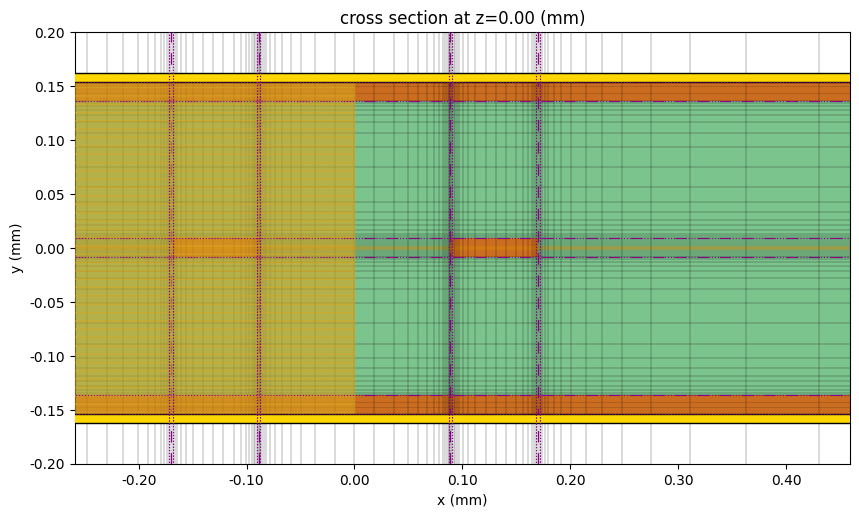

In [15]:
# Inspect transverse grid
fig, ax = plt.subplots(figsize=(10, 6))
sim.plot(z=1, ax=ax)
sim.plot_grid(z=1, ax=ax, hlim=(-w - se, w + se + 200), vlim=(-200, 200))
plt.show()

## 2D Analysis

Before running the 3D simulation, let us first perform a 2D `ModeSolver` calculation. From the `ModeSolver` results, we can obtain all the key transmission line parameters, such as attenuation $\alpha$, characteristic impedance $Z_0$, and effective index $n_{\text{eff}}$. 

Since we have previously defined a `WavePort`, we can skip the usual setup process and use the `to_mode_solver()` method to quickly define a `ModeSolver` simulation. 

In [16]:
# Convert wave port to mode solver
mode_solver = WP1.to_mode_solver(sim, freqs)

We execute the mode solver study below. 

In [17]:
mode_data = td.web.run(mode_solver, task_name="mode solver")

20:00:17 CEST Created task 'mode solver' with task_id                           
              'mo-604e9d1b-cb0e-4ad7-8c67-452dbc05d0f6' and task_type           
              'MODE_SOLVER'.

              View task using web UI at                                         
              ]8;id=265169;https://tidy3d.simulation.cloud/workbench?taskId=mo-604e9d1b-cb0e-4ad7-8c67-452dbc05d0f6\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=843138;https://tidy3d.simulation.cloud/workbench?taskId=mo-604e9d1b-cb0e-4ad7-8c67-452dbc05d0f6\taskId]8;;\]8;id=265169;https://tidy3d.simulation.cloud/workbench?taskId=mo-604e9d1b-cb0e-4ad7-8c67-452dbc05d0f6\=]8;;\]8;id=379974;https://tidy3d.simulation.cloud/workbench?taskId=mo-604e9d1b-cb0e-4ad7-8c67-452dbc05d0f6\mo]8;;\]8;id=265169;https://tidy3d.simulation.cloud/workbench?taskId=mo-604e9d1b-cb0e-4ad7-8c67-452dbc05d0f6\-604e9d1b-cb0e]8;;\
              ]8;id=265169;https://tidy3d.simulation.cloud/workbench?taskId=mo-604e9d1b-cb0e-4ad7-8c67-452dbc05d0f6\-4ad7-8c67-452dbc05d0f6']8;;\.

              Task folder: ]8;id=356774;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

20:00:19 CEST Maximum FlexCredit cost: 0.014. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

20:00:20 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

20:00:25 CEST starting up solver

              running solver

20:00:37 CEST status = success

              View simulation result at                                         
              ]8;id=432424;https://tidy3d.simulation.cloud/workbench?taskId=mo-604e9d1b-cb0e-4ad7-8c67-452dbc05d0f6\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=713939;https://tidy3d.simulation.cloud/workbench?taskId=mo-604e9d1b-cb0e-4ad7-8c67-452dbc05d0f6\taskId]8;;\]8;id=432424;https://tidy3d.simulation.cloud/workbench?taskId=mo-604e9d1b-cb0e-4ad7-8c67-452dbc05d0f6\=]8;;\]8;id=213059;https://tidy3d.simulation.cloud/workbench?taskId=mo-604e9d1b-cb0e-4ad7-8c67-452dbc05d0f6\mo]8;;\]8;id=432424;https://tidy3d.simulation.cloud/workbench?taskId=mo-604e9d1b-cb0e-4ad7-8c67-452dbc05d0f6\-604e9d1b-cb0e]8;;\
              ]8;id=432424;https://tidy3d.simulation.cloud/workbench?taskId=mo-604e9d1b-cb0e-4ad7-8c67-452dbc05d0f6\-4ad7-8c67-452dbc05d0f6']8;;\.

Output()

20:00:41 CEST loading simulation from simulation_data.hdf5

Below, the `Ey` and `Ex` components of the mode field are plotted at the center frequency. The integration paths for the impedance calculation are also shown (current in blue and voltage in red). 

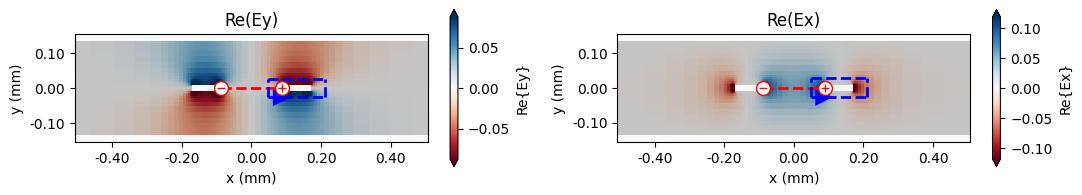

In [18]:
# Plot mode field
fig, ax = plt.subplots(1, 2, figsize=(11, 2), tight_layout=True)
mode_solver.plot_field(field_name="Ey", val="real", mode_index=0, f=f0, ax=ax[0])
mode_solver.plot_field(field_name="Ex", val="real", mode_index=0, f=f0, ax=ax[1])
for axis in ax:
    voltage_integral.plot(z=-L / 2, ax=axis)
    current_integral.plot(z=-L / 2, ax=axis)
    axis.set_xlim(-20 * mil, 20 * mil)
ax[0].set_title("Re(Ey)")
ax[1].set_title("Re(Ex)")
plt.show()

The mode solver solution data includes $n_{\text{eff}}$ and attenuation $\alpha$ in dB/cm. From this, we can also derive the real part of the propagation constant, $\beta$, as well as the complex propagation constant $\gamma$. 

In [19]:
# Gather alpha, neff from mode solver results
neff_mode = mode_data.modes_info["n eff"].squeeze()
alphadB_mode = mode_data.modes_info["loss (dB/cm)"].squeeze()

# Calculate beta, alpha (in 1/um), and gamma
beta_mode = 2 * np.pi * freqs * neff_mode / td.C_0
alpha_mode = alphadB_mode / 8.686 / 1e4
gamma_mode = alpha_mode + 1j * beta_mode

We obtain $Z_0$ by calling the `compute_impedance()` method in the [`ImpedanceCalculator`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.microwave.ImpedanceCalculator.html) class, making use of the previously defined current and voltage integrals.

In [20]:
Z0_mode = (
    mw.ImpedanceCalculator(voltage_integral=voltage_integral, current_integral=current_integral)
    .compute_impedance(mode_data)
    .isel(mode_index=0)
)

Let's import some benchmark data for comparison. We will use mode data from a commercial FEM and FIT solver respectively. 

In [21]:
# Import benchmark data
freqs_ben1, neff_ben1, alphadB_ben1, Z0_ben1 = np.loadtxt(
    "./misc/stripline_fem_mode.csv", delimiter=",", skiprows=1, unpack=True
)
freqs_ben2, neff_ben2, alphadB_ben2, Z0_ben2 = np.loadtxt(
    "./misc/stripline_fit_mode.txt", delimiter=",", unpack=True
)

Let's compare the effective index $n_{\text{eff}}$.

In [22]:
def plot_data_and_band(data, err_band, ax, label=""):
    """Plots frequency-domain data together with a fractional error band"""
    ax.plot(freqs / 1e9, data, label=label, color="#328362")
    ax.fill_between(
        freqs / 1e9,
        (1 + err_band) * data,
        (1 - err_band) * data,
        alpha=0.5,
        color="#DDDDDD",
        label=f"+/-{err_band * 100:.2f}%",
    )
    ax.legend()

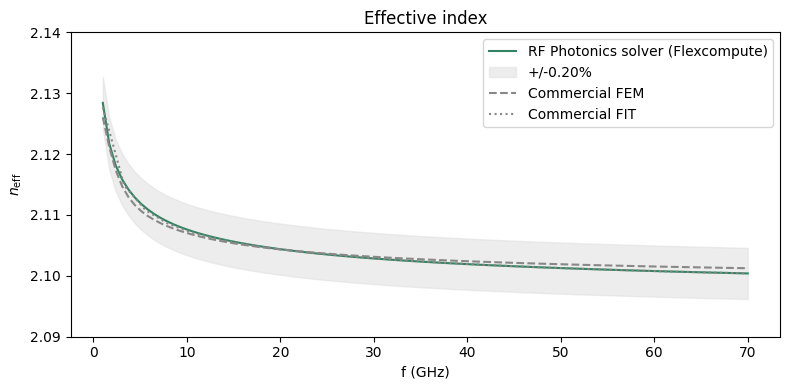

In [23]:
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True)
plot_data_and_band(neff_mode, 0.002, ax=ax, label="RF Photonics solver (Flexcompute)")
ax.plot(freqs_ben1, neff_ben1, "--", color="#888888", label="Commercial FEM")
ax.plot(freqs_ben2, neff_ben2, ":", color="#888888", label="Commercial FIT")
ax.set_title("Effective index")
ax.set_xlabel("f (GHz)")
ax.set_ylabel("$n_{\\text{eff}}$")
ax.set_ylim(2.09, 2.14)
ax.legend()
plt.show()

We observe that $n_{\text{eff}}$ is in good agreement with the benchmarks, and is close to the substrate index $\sqrt \epsilon \approx 2.10$.

Next, let's compare the transmission line losses $\alpha$ (dB/cm).

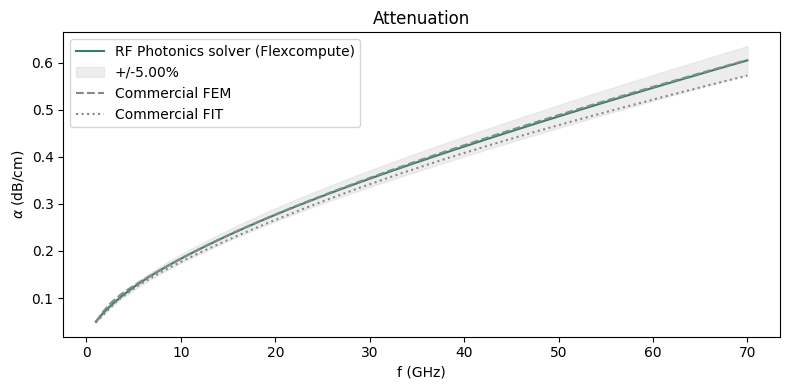

In [24]:
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True)
plot_data_and_band(alphadB_mode, 0.05, ax=ax, label="RF Photonics solver (Flexcompute)")
ax.plot(freqs_ben1, alphadB_ben1, "--", color="#888888", label="Commercial FEM")
ax.plot(freqs_ben2, alphadB_ben2, ":", color="#888888", label="Commercial FIT")
ax.set_title("Attenuation")
ax.set_xlabel("f (GHz)")
ax.set_ylabel("$\\alpha$ (dB/cm)")
ax.legend()
plt.show()

Although the metal and substrate mediums are both lossy in this simulation, the metal losses dominate in this frequency range and scale as $f^{1/2}$ due to the skin depth. 

Let's compare the impedance $Z_0$ of the differential mode. 

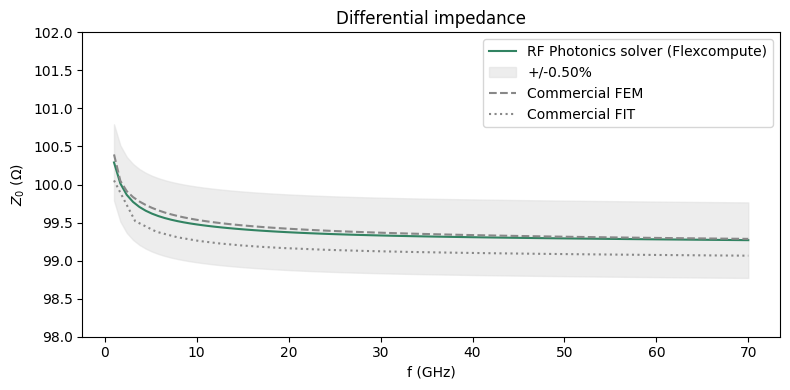

In [25]:
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True)
plot_data_and_band(np.real(Z0_mode), 0.005, ax=ax, label="RF Photonics solver (Flexcompute)")
ax.plot(freqs_ben1, Z0_ben1, "--", color="#888888", label="Commercial FEM")
ax.plot(freqs_ben2, Z0_ben2, ":", color="#888888", label="Commercial FIT")
ax.set_title("Differential impedance")
ax.set_xlabel("f (GHz)")
ax.set_ylabel("$Z_0$ ($\\Omega$)")
ax.set_ylim(98, 102)
ax.legend()
plt.show()

## 3D Analysis

Since the transmission line is longitudinally invariant, the results of the 2D analysis can fully describe the propagating TEM mode. 

That said, for tutorial purposes, we will demonstrate how to perform a 3D full-wave simulation to obtain S-parameters. We will be simulating a 4 inch length of the transmission line, which is quite optically large. The level of grid refinement required for converged S-parameters is lower than those used for the 2D solver. To reduce the simulation cost, we define a grid specification with reduced refinement below. 

In [26]:
# Update layer refinement with reduced fidelity
lr_spec_3d = lr_spec.updated_copy(
    min_steps_along_axis=3,
    corner_refinement=td.GridRefinement(dl=t / 2, num_cells=2),
)

# Similarly for top and bottom ground planes
lr_spec2_3d = lr_spec_3d.updated_copy(center=(0, h / 2 + t / 2, 0), size=(len_inf, t, len_inf))
lr_spec3_3d = lr_spec_3d.updated_copy(center=(0, -h / 2 - t / 2, 0), size=(len_inf, t, len_inf))

# Update overall grid specification
grid_spec_3d = grid_spec.updated_copy(layer_refinement_specs=[lr_spec_3d, lr_spec2_3d, lr_spec3_3d])

# Update sim and TCM
sim_3d = sim.updated_copy(grid_spec=grid_spec_3d)
tcm_3d = tcm.updated_copy(simulation=sim_3d)

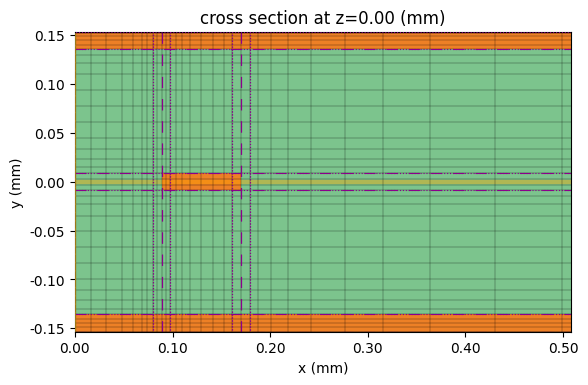

In [27]:
# Plot the simplified 3D grid
fig, ax = plt.subplots()
sim_3d.plot(z=0, ax=ax)
sim_3d.plot_grid(z=0, ax=ax, hlim=(0, 20 * mil))
plt.show()

We execute the `TerminalComponentModeler` below. The output of the `run` method is the full S-matrix.

In [28]:
# s_matrix_long = tcm_long.run()
s_matrix = tcm_3d.run()

Output()

20:00:45 CEST Started working on Batch containing 2 tasks.

20:00:48 CEST Maximum FlexCredit cost: 1.193 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

20:14:16 CEST Batch complete.

Output()

In [29]:
# Report cost of simulation
_ = tcm_3d.batch.real_cost()

20:14:36 CEST Total billed flex credit cost: 0.864.

We use the `port_in` and `port_out` parameters to select the corresponding entry of the S-matrix. 

In [30]:
# Get S-parameters
S11 = np.conjugate(s_matrix.sel(port_in="WP1", port_out="WP1"))
S21 = np.conjugate(s_matrix.sel(port_in="WP1", port_out="WP2"))

In [31]:
# Import benchmark data
freqs_ben1, S11abs_ben1, S21abs_ben1 = np.loadtxt(
    "./misc/stripline_fem_sparam_long.csv", delimiter=",", skiprows=1, unpack=True
)
freqs_ben2, S11abs_ben2, S21abs_ben2 = np.loadtxt(
    "./misc/stripline_fit_sparams_long.txt", delimiter=",", unpack=True
)

The insertion loss magnitude is plotted below.

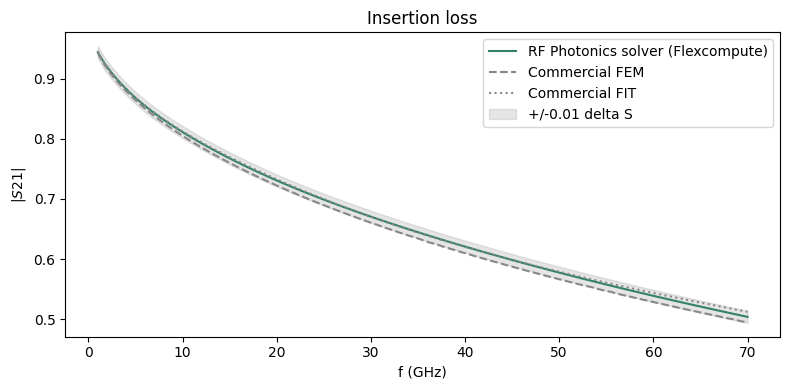

In [32]:
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True)
ax.plot(freqs / 1e9, np.abs(S21), label="RF Photonics solver (Flexcompute)", color="#328362")
ax.plot(freqs_ben1, S21abs_ben1, "--", color="#888888", label="Commercial FEM")
ax.plot(freqs_ben2, S21abs_ben2, ":", color="#888888", label="Commercial FIT")
ax.fill_between(
    freqs / 1e9,
    np.abs(S21) + 0.01,
    np.abs(S21) - 0.01,
    alpha=0.2,
    color="gray",
    label="+/-0.01 delta S",
)
ax.set_title("Insertion loss")
ax.set_ylabel("$|S21|$")
ax.set_xlabel("f (GHz)")
ax.legend()
plt.show()

In controlled testing, the RF solver is able to solve this relatively large model in about 3.5 minutes on two A100 GPUs.

For comparison, this problem took about 1 hour to solve using the commercial FIT software, and close to 12 hours using the commercial FEM software. Benchmarking was done using a 20-core desktop workstation with 256 GB of RAM. 

Below, we plot `Ex` in the signal plane at maximum frequency (f = 70 GHz).

In [33]:
# Load monitor data
tcm_batch = tcm_3d.batch.load()
sim_data = tcm_batch["smatrix_WP1"]

Output()

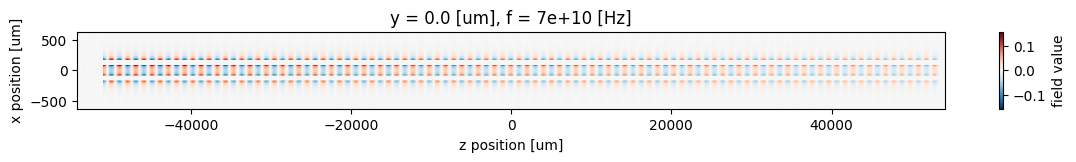

In [34]:
# Field plot
fig, ax = plt.subplots(figsize=(14, 1))
ex = sim_data["longitudinal field (y=0)"].Ex.sel(f=f_max, method="nearest")
np.real(ex).plot(
    x="z",
    y="x",
    ax=ax,
)
ax.set_ylim(-25 * mil, 25 * mil)
plt.show()